<a href="https://colab.research.google.com/github/vladachini/ARMenu/blob/main/W2025/Assignments/Assignment2/Ass2_SYSC4415_W25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSC4415 Assignment 2 – Fire Hydrant Detection 🚒

"""
Special thanks to Nader Ibrahim for assembling the dataset. For more details, please refer to the paper:

Ibrahim N, Dick K, Green JR. Computer Vision Fire Hydrant Obstruction Detection System. In2024 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE) 2024 Aug 6 (pp. 799-805). IEEE.


Questions? Please use the Brightspace Discussion Board.

Deadline: See Brightspace end date.
"""

## Instructions
DO NOT wait until the last minute to complete this assignment as training the models might take longer. Also leverage the free GPU provided by colab to make your training faster.


Follow all steps carefully. Your solutions must be self-contained in this notebook. No other supplementary materials or files will be accepted. As soon as I open your notebook, I will click "Runtime" → "Run all". Ensure your notebook runs without errors and displays results clearly.


You are asked to provide both code and text to address discussion questions. For the text answers, see the markdown cells with the ❓ emoji for questions and enter your answers following the ✅ emoji.

Provide sufficient comments in your code to describe its functionality. Do not remove any necessary libraries as this will cause errors.

Download the dataset from Brightspace and store it in your Google Drive under "My Drive" (not in any subfolder). Check the file location via right-click → File Information → Details → Location.

Submit your notebook as a `.ipynb` file named: `SYSC4415W25_A2_FIRSTNAME_LASTNAME_StudentID.ipynb` on Brightspace. No other submission methods will be accepted.


## Dataset
Provided on Brightspace.

#### Dataset details:
- Training Images: 2,272  
- Validation Images: 563  
- Labels: 0 = No Fire Hydrant, 1 = Fire Hydrant  
- Imbalanced dataset (most images do not contain a hydrant).

#### Dataset Information
The dataset contains two main folders:
- `train/`: Contains the training images and a CSV file with labels.
- `valid/`: Contains the validation images and a CSV file with labels.

Each folder includes:
- Images of fire hydrants and non-fire hydrants.
- A CSV file (`_classes.csv`) mapping each image filename to its label:
  - `0` for no fire hydrant.
  - `1` for fire hydrant.

Ensure the zip file of the dataset (FH_detection_data.zip) to your Google Drive and placed under "My Drive" without any subfolders to keep the paths consistent.



## Steps

### 1) Initial Setup
Import necessary libraries


In [3]:
# Import all the necessary libraries here

import pandas as pd
import os

Mount Google Drive and unzip the dataset.

In [6]:
## Code provided by Akash. DO NOT CHANGE THIS CELL

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip /content/drive/MyDrive/FH_detection_data.zip -d /content/

# Dataset path
train_data_path = "/content/train"
valid_data_path = "/content/valid"
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')

----

### 2) Data Exploration
1. Load dataset into a pandas DataFrame.
2. Display display three sample images from each class
3. Create separately class distribution plots of the train and validation data
[Requires 6 sample images (three from each class) and two plots of class distribution (train and validation)]

❓ Why is it important to check for class imbalance before training? How might this affect our model?  
✅ Your answer here

Class imbalance can lead to a model that favors the majority class, which lowers its chance to correctly identify the minority class. For example in this dataset, since it's imbalanced (favoring non fire hydrant), the model learns to predict "No Fire Hydrant" most of the time, so it may achieve high accuracy but fail to detect fire hydrants effectively


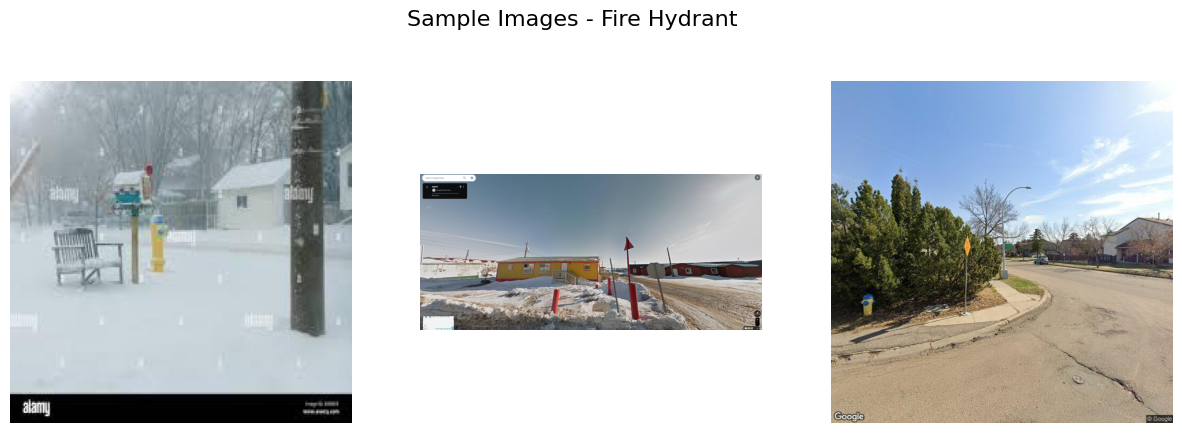

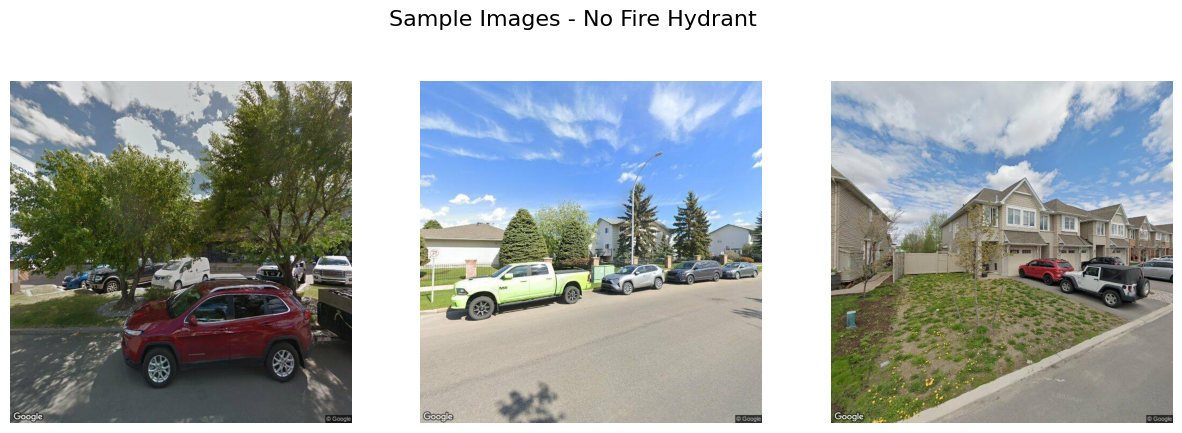

<ipython-input-7-13ceff6bd6ff>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["No Fire Hydrant", "Fire Hydrant"])
<ipython-input-7-13ceff6bd6ff>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["No Fire Hydrant", "Fire Hydrant"])


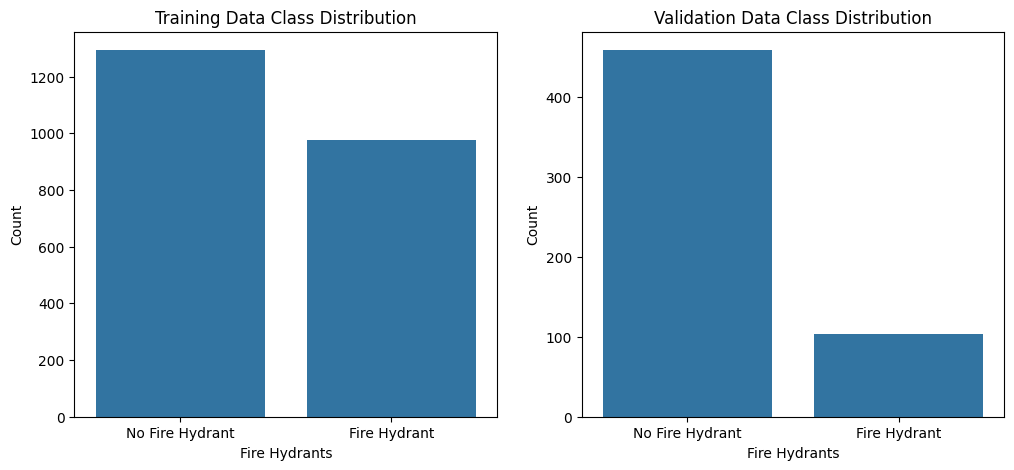

In [7]:
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset into pandas DataFrame
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')

# Display the first few rows of the training labels
train_label.head()

# Function to load and display sample images
def display_images(image_filenames, title, folder_path):
    fig, axes = plt.subplots(1, len(image_filenames), figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for ax, img_file in zip(axes, image_filenames):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis("off")

    plt.show()

# Choose 3 sample images for each class
fire_hydrant_samples = train_label[train_label["Fire Hydrants"] == 1].sample(3, random_state=42)["filename"].tolist()
no_fire_hydrant_samples = train_label[train_label["Fire Hydrants"] == 0].sample(3, random_state=42)["filename"].tolist()

# Display images
display_images(fire_hydrant_samples, "Sample Images - Fire Hydrant", train_data_path)
display_images(no_fire_hydrant_samples, "Sample Images - No Fire Hydrant", train_data_path)

# Plot class distributions for training and validation datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training dataset distribution
sns.countplot(x=train_label["Fire Hydrants"], ax=axes[0])
axes[0].set_title("Training Data Class Distribution")
axes[0].set_xticklabels(["No Fire Hydrant", "Fire Hydrant"])
axes[0].set_ylabel("Count")

# Validation dataset distribution
sns.countplot(x=valid_label["Fire Hydrants"], ax=axes[1])
axes[1].set_title("Validation Data Class Distribution")
axes[1].set_xticklabels(["No Fire Hydrant", "Fire Hydrant"])
axes[1].set_ylabel("Count")

plt.show()

---

### 3) Preprocessing
- Resize images to 128x128.
- Apply any other necessary transformations that you feel can help.

❓ Would one-hot encoding be necessary for binary classification? Why or why not?  

No, one-hot encoding is not necessary for binary classification here since the labels area already 0 or 1, therefore we can use them directly in a binary cross-entropy loss function. One-hot encoding is more useful for multi-class classification problems where youi have 3 or more categories

In [8]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

# Custom dataset class
class FireHydrantDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.labels.iloc[idx, 1])  # Get label (0 or 1)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = FireHydrantDataset(csv_file='/content/train/_classes.csv', root_dir='/content/train', transform=image_transforms)
valid_dataset = FireHydrantDataset(csv_file='/content/valid/_classes.csv', root_dir='/content/valid', transform=image_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


---

### 4) Creating the Baseline Model
Create a CNN with:
- Two convolutional layers to extract features from the images.
- Max pooling layers after each convolution to reduce spatial dimensions.
- Fully connected layers to perform classification.
- A sigmoid activation function at the output layer to output a probability between 0 and 1.

Required architecture:
- Input: RGB images resized to 128x128 pixels.
- Conv2d (3 input channels, 32 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the first Conv2d.
- Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the second Conv2d.
- Flatten
- Linear layer with 128 units
- Output Linear layer with 1 unit and sigmoid activation



This model will be trained to classify whether an image contains a fire hydrant or not.


❓ List three ways to improve the baseline model (e.g., adding dropout to... , using batch normalization to..., or increasing the number of layers to...,
be sure to come up with your own ideas!). Provide a brief explanation for each.

Here are some ways we can improve the baseline model:

1. Add dropout layers to help prevent overfitting by randomly disabling some neurons during training. For example we can add a dropout between fc1 and fc2 to improve generalization.

2. Use batch normalization to help stabilize training and imrpove the convergence speed. For example we can add it after each conv2D layer to normalize the features.

3. Increase the number of layers to allow the model to learn deeper features for better accuracy, but we should be careful to not makle it memorize/overfit. For example we can add another conv2D layer (64-> 128) before flattening.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define CNN model
class FireHydrantCNN(nn.Module):
    def __init__(self):
        super(FireHydrantCNN, self).__init__()

        # First Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second Convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Output from conv layer is 64x32x32
        self.fc2 = nn.Linear(128, 1)  # Single neuron output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = torch.sigmoid(self.fc2(x))  # Output Layer (Sigmoid Activation)
        return x

model = FireHydrantCNN()

# Print model summary
print(model)

FireHydrantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


---

### 5) Training and Evaluation
Train your CNN using Binary Cross Entropy Loss and an Adam optimizer. Use a learning rate of 0.001. Iterate over your dataset for 10 epochs and track the loss. Train using the train data in /train.

Evaluate your model on the test data in /valid using Precision, Recall, and F1-Score to assess performance.


❓ Which evaluation metric you think is the most suitable in our case, and why?

I think that recall is the most important metric in our case since we are trying to detect fire hydrants so we want to minimize false negatives (missing a fire hydrant when it's present). If we predict "No Fire Hydrant" incorrectly, it might lead to important hydrants being missed in real-world applications.


Display the confusion matrix.

❓ Explain the confusion matrix to a non-technical audience and relate it to your chosen metric.  

A confusion matrix shows how many times the model was correct and incorrect for both classes.

True Positive: Correctly identified fire hydrants, in our case TP is 73
True Negative: Correctly identified non-hydrant, in our case TN is 354
False Positives: Mistakenly deteced a hydrant when none exists,we have FP=105
False Negatives: Missed detecting a hydrant when it was there, we have FN= 31

Since recall is important for us, we want to focus on reducing False Negatives to make sure we don't miss real hydrants. Recall is TP / (TP + FN) so in our case:

Recall = 73 / (73+31) = 73 / 104 = 0.702

In [15]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EPOCHS = 10
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move to GPU, reshape labels
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

print("Training complete!")

Epoch 1/10, Loss: 0.5914
Epoch 2/10, Loss: 0.5069
Epoch 3/10, Loss: 0.4469
Epoch 4/10, Loss: 0.3837
Epoch 5/10, Loss: 0.3055
Epoch 6/10, Loss: 0.2134
Epoch 7/10, Loss: 0.1281
Epoch 8/10, Loss: 0.0747
Epoch 9/10, Loss: 0.0391
Epoch 10/10, Loss: 0.0311
Training complete!


In [16]:
# Set model to evaluation mode
model.eval()
y_true = []
y_pred = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device).cpu().numpy()  # Move images to GPU
        outputs = model(images)  # Forward pass
        preds = (outputs.cpu().numpy() > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

        y_true.extend(labels)
        y_pred.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.4101
Recall: 0.7019
F1-score: 0.5177


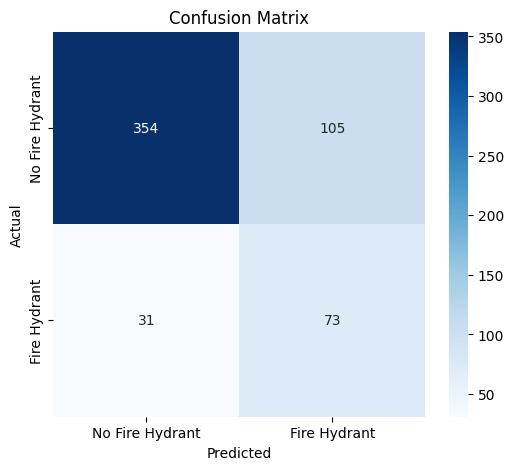

In [17]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire Hydrant", "Fire Hydrant"], yticklabels=["No Fire Hydrant", "Fire Hydrant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

---


### 6) Model Improvements
Apply and evaluate three improvements ideas that you mentioned in the Baseline CNN question (Step 4).
Implement each idea separately, train a model with that improvement, and report the performance of each model using the metrics from Step 5. As above, train using the data in /train and test using the data in /valid.


❓ Which model would you deploy? Why?  
✅ Your answer here

In [20]:
class FireHydrantCNN_Dropout(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.5)  # Dropout added
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))
        return x

class FireHydrantCNN_BatchNorm(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Norm added
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Norm added
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply Batch Norm
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Apply Batch Norm
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class FireHydrantCNN_Deep(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_Deep, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Extra pooling
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # Adjusted size
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))  # Extra Conv Layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x




Training & Evaluating Dropout Model:
Epoch 1: Loss = 0.5739
Epoch 2: Loss = 0.4966
Epoch 3: Loss = 0.4428
Epoch 4: Loss = 0.3845
Epoch 5: Loss = 0.3086
Epoch 6: Loss = 0.2526
Epoch 7: Loss = 0.1935
Epoch 8: Loss = 0.1485
Epoch 9: Loss = 0.1064
Epoch 10: Loss = 0.0996
Precision: 0.4250, Recall: 0.6538, F1-score: 0.5152


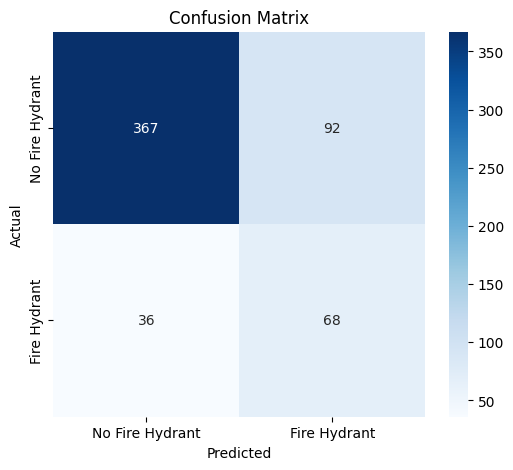

Training & Evaluating BatchNorm Model:
Epoch 1: Loss = 3.9531
Epoch 2: Loss = 1.1375
Epoch 3: Loss = 0.7941
Epoch 4: Loss = 0.5155
Epoch 5: Loss = 0.3285
Epoch 6: Loss = 0.2617
Epoch 7: Loss = 0.1942
Epoch 8: Loss = 0.2279
Epoch 9: Loss = 0.1602
Epoch 10: Loss = 0.1240
Precision: 0.5761, Recall: 0.5096, F1-score: 0.5408


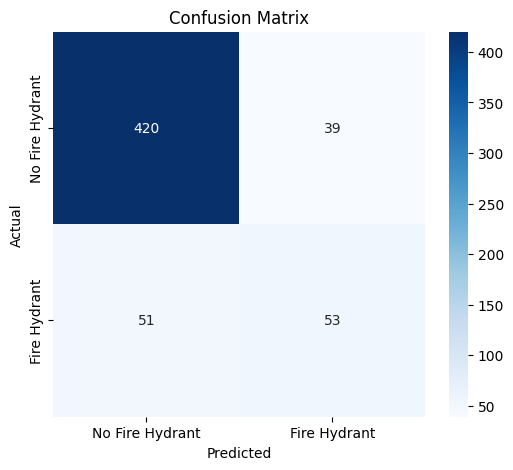

Training & Evaluating Deep Model:
Epoch 1: Loss = 0.5790
Epoch 2: Loss = 0.4993
Epoch 3: Loss = 0.4613
Epoch 4: Loss = 0.4252
Epoch 5: Loss = 0.3805
Epoch 6: Loss = 0.3275
Epoch 7: Loss = 0.2595
Epoch 8: Loss = 0.1832
Epoch 9: Loss = 0.1166
Epoch 10: Loss = 0.0813
Precision: 0.4417, Recall: 0.6923, F1-score: 0.5393


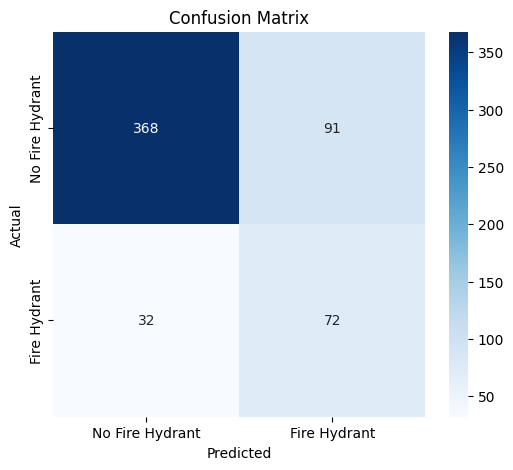

In [21]:
def train_and_evaluate(model):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Training
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.cpu().numpy()
            outputs = model(images)
            preds = (outputs.cpu().numpy() > 0.5).astype(int)
            y_true.extend(labels)
            y_pred.extend(preds)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire Hydrant", "Fire Hydrant"], yticklabels=["No Fire Hydrant", "Fire Hydrant"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

model_batchnorm = FireHydrantCNN_BatchNorm()
model_dropout = FireHydrantCNN_Dropout()
model_deep = FireHydrantCNN_Deep()

# Train and evaluate each model
print("Training & Evaluating Dropout Model:")
train_and_evaluate(model_dropout)

print("Training & Evaluating BatchNorm Model:")
train_and_evaluate(model_batchnorm)

print("Training & Evaluating Deep Model:")
train_and_evaluate(model_deep)

---

### 7) Personal Inference Test
Test your trained model on at least FIVE new images (either collected using a camera or collected from the internet). Predict whether each image contains a fire hydrant and print the result.

Of your five images:
- Include at least one image of a fire hydrant that your model does not detect correctly.
- Include at least one image of a fire hydrant that your model does detect correctly.

❓ Challenge: Can you find an image that does not actually contain a fire hydrant, but your model believes that a hydrant is present?

✅ Your answer here

❓ Explain why you believe your model performed the way it did on each of your five images. What patterns or mistakes do you observe?

✅ Your answer here


In [ ]:
## Enter your code here..

---

### 8) (Optional) Transfer Learning with Pretrained CNN

#### Description:
In this optional step, fine-tune a pretrained CNN (e.g., ResNet50) on your dataset and compare its performance to your custom CNN.

- Use `torchvision.models.resnet50(pretrained=True)` as a starting model.

Reference: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
- Modify the final layer to fit your binary classification task (fire hydrant vs. no fire hydrant).
- Resize input images to **256x256** pixels.
- Fine-tune the model and evaluate its performance.
- Compare the results to your custom CNN in terms of accuracy, training time, and other relevant metrics.

#### Libraries to use:
```python
import torchvision.models as models
```

#### Student Code:
```python
# Your code here
```


------

### 9) Final Thoughts
❓ How would you improve the model in the future?

✅ Your answer here..


-----

## Final Question:
### ❓ Did you use an AI tool in completing your assignment? If yes, which AI tool(s) did you use? How did you prompt it? How you validate the response?

✅ Your answer here..


---

## Submission
Submit your `.ipynb` notebook on Brightspace using the following name format:  
`SYSC4415W25_A2_FIRSTNAME_LASTNAME_StudentID.ipynb`

